In [3]:
#Load Library
import os
import numpy as np
import glob
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [6]:
#Checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [ ]:
#Dataloader

#Path for training and testing directory
train_path='C:\\Users\\manav\\OneDrive\\Desktop\\SOC GANs project\\archive\\seg_train\\seg_train'
test_path='C:\\Users\\manav\\OneDrive\\Desktop\\SOC GANs project\\archive\\seg_test\\seg_test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=16, shuffle=True
)

In [14]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [15]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output

In [20]:
model=ConvNet(num_classes=6).to(device)

In [21]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [22]:
num_epochs=10

In [23]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [24]:
print(train_count,test_count)

14034 3000


In [ ]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob

train_path='C:\\Users\\manav\\OneDrive\\Desktop\\SOC GANs project\\archive\\seg_train\\seg_train'
pred_path='C:\\Users\\manav\\OneDrive\\Desktop\\SOC GANs project\\archive\\seg_pred\\seg_pred'

#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
    
    
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_classes=6)
model.load_state_dict(checkpoint)
model.eval()

#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])


#prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred=classes[index]
    
    return pred


images_path=glob.glob(pred_path+'/*.jpg')
pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)
    
pred_dict


In [3]:
import pandas as pd
import quandl

quandl.ApiConfig.api_key = 'uksmNsyTcYtvtfyiyGsS'
msft_data = quandl.get("EOD/MSFT", start_date="01-09-2017", end_date="01-10-2017")
msft_data.head()


msft_data.info()

ModuleNotFoundError: No module named 'quandl'

In [2]:
# assigning adjusted closing prices to adj_prices
adj_price = msft_data['Adj_Close']
# calculate the moving average
mav = adj_price.rolling(window=50).mean()
# print the result
print(mav[-10:])


NameError: name 'msft_data' is not defined

In [4]:
# step1: initialize the short and long lookback periods
short_lb = 50
long_lb = 120
# step2: initialize a new DataFrame called signal_df with the signal column
signal_df = pd.DataFrame(index=msft_data.index)
signal_df['signal'] = 0.0
# step3: create a short simple moving average over the short lookback period
signal_df['short_mav'] = msft_data['Adj_Close'].rolling(window=short_lb, min_periods=1, center=False).mean()
# step4: create long simple moving average over the long lookback period
signal_df['long_mav'] = msft_data['Adj_Close'].rolling(window=long_lb, min_periods=1, center=False).mean()
# step5: generate the signals based on the conditional statement
signal_df['signal'][short_lb:] = np.where(signal_df['short_mav'][short_lb:] > signal_df['long_mav'][short_lb:], 1.0, 0.0)   
# step6: create the trading orders based on the positions column
signal_df['positions'] = signal_df['signal'].diff()
signal_df[signal_df['positions'] == -1.0]

NameError: name 'msft_data' is not defined

In [5]:
# initialize the plot using plt
fig = plt.figure()
# Add a subplot and label for y-axis
plt1 = fig.add_subplot(111,  ylabel='Price in $')
msft_data['Adj_Close'].plot(ax=plt1, color='r', lw=2.)
# plot the short and long lookback moving averages
signal_df[['short_mav', 'long_mav']].plot(ax=plt1, lw=2., figsize=(12,8))
# plotting the sell signals
plt1.plot(signal_df.loc[signal_df.positions == -1.0].index, 
         signal_df.short_mav[signal_df.positions == -1.0],
         'v', markersize=10, color='k')
# plotting the buy signals
plt1.plot(signal_df.loc[signal_df.positions == 1.0].index, 
         signal_df.short_mav[signal_df.positions == 1.0],
         '^', markersize=10, color='m')
# Show the plot
plt.show()

NameError: name 'plt' is not defined

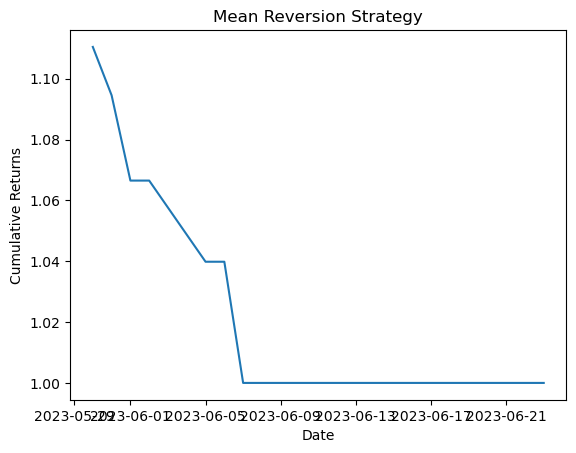

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load historical price data into a pandas DataFrame
data = pd.read_csv("C:\\Users\\manav\\Downloads\\Download Data - STOCK_US_XNYS_CSV.csv")

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Calculate the mean and standard deviation of the price data
mean = data['Close'].mean()
std = data['Close'].std()

# Define the entry and exit thresholds for mean reversion
entry_threshold = 1.0  # Number of standard deviations from the mean to enter a position
exit_threshold = 0.5  # Number of standard deviations from the mean to exit a position


# Calculate the upper and lower bounds for entering and exiting positions
upper_bound = mean + entry_threshold * std
lower_bound = mean - entry_threshold * std
exit_upper_bound = mean + exit_threshold * std
exit_lower_bound = mean - exit_threshold * std

# Initialize a column for the trading signals
data['Signal'] = 0

# Generate trading signals based on the mean reversion strategy
data.loc[data['Close'] > upper_bound, 'Signal'] = -1  # Enter a short position
data.loc[data['Close'] < lower_bound, 'Signal'] = 1  # Enter a long position
data.loc[(data['Close'] > exit_lower_bound) & (data['Close'] < exit_upper_bound), 'Signal'] = 0  # Exit a position

# Calculate the daily returns based on the trading signals
data['Returns'] = data['Close'].pct_change() * data['Signal'].shift()

# Calculate the cumulative returns
data['Cumulative Returns'] = (1 + data['Returns']).cumprod()

# Plot the cumulative returns
plt.plot(data['Cumulative Returns'])
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Mean Reversion Strategy')
plt.show()
